# Mobility in Sionna RT

This notebook explains different ways in which the effects of mobility can be simulated with Sionna's [ray tracing (RT) module](https://nvlabs.github.io/sionna/api/rt.html). In particular, you will

- Use the `position` and `orientation` properties to move scene objects
- Understand the `velocity` property of scene objects and their impact on the Doppler shift
- Learn how to use the `apply_dopper` method of a `Paths` object

## Table of Contents
* [Background Information](#Background-Information)
* [GPU Configuration and Imports](#GPU-Configuration-and-Imports)
* [Controlling Position and Orientation of Scene Objects](#Controlling-Position-and-Orientation-of-Scene-Objects)
* [Time Evolution of Channels Via Doppler Shift](#Time-Evolution-of-Channels-Via-Doppler-Shift)
  * [Example: Delay-Doppler Spectrum](#Example:-Delay-Doppler-Spectrum)
* [Comparison of Doppler- vs Position-based Time Evolution](#Comparison-of-Doppler--vs-Position-based-Time-Evolution)
* [Summary](#Summary)

## Background Information

There are two ways in which we can simulate the impact of movement of scene objects on the channel impulse response. The first consists in moving the desired objects in small steps along a trajectory and recomputing the propagation paths for each step. While this approach is the most accurate, it comes at the cost of high computational complexity. As we will see later in this notebook, this approach is fortunately not necessary when the lengths of the considered trajectories are small, i.e., not more than a few wavelengths. In this case, we can compute the time evolution of the channel impulse response using the second approach which is based on the experienced Doppler shifts of all propagation paths. It is very fast and leads to very accurate predictions in many cases.

In order to compute the Doppler shift for a specific path as shown in the figure below, Sionna RT relies on the [velocity vectors](https://nvlabs.github.io/sionna/api/rt.html#sionna.rt.SceneObject.velocity) of the scene objects. 

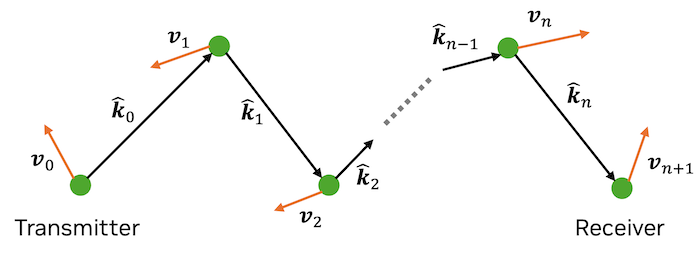

While traveling from the transmitter to the receiver, the path undergoes $n$ scattering processes, such as reflection, diffuse scattering, or diffraction. The object on which lies the $i$th scattering point has the velocity vector $\mathbf{v}_i$ and the outgoing ray direction at this point is denoted $\hat{\mathbf{k}}_i$. The first and last point correspond to the transmitter and receiver, respectively. 

The Doppler shift $f_\Delta$ for this path can be computed as (see the [documentation](https://nvlabs.github.io/sionna/api/rt.html#sionna.rt.Paths.apply_doppler) of `Paths.apply_doppler()`)

\begin{align}
f_\Delta = \frac{1}{\lambda}\left[\mathbf{v}_{0}^\mathsf{T}\hat{\mathbf{k}}_0 - \mathbf{v}_{n+1}^\mathsf{T}\hat{\mathbf{k}}_n + \sum_{i=1}^n \mathbf{v}_{i}^\mathsf{T}\left(\hat{\mathbf{k}}_i-\hat{\mathbf{k}}_{i-1} \right) \right] \qquad \text{[Hz]}
\end{align}

where $\lambda$ is the wavelength, and then be used to compute the time evolution of the path coefficient `Paths.a`
as

\begin{align}
a(t) = a e^{j2\pi f_\Delta t}.
\end{align}


## GPU Configuration and Imports <a class="anchor" id="GPU-Configuration-and-Imports"></a>

In [1]:
import os # Configure which GPU 
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e) 

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we 
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    no_preview = True # deactivate preview
except:
    if os.getenv("SIONNA_NO_PREVIEW"):
        no_preview = True
    else:
        no_preview = False

resolution = [480,320] # increase for higher quality of renderings

# Define magic cell command to skip a cell if needed
from IPython.core.magic import register_cell_magic
from IPython import get_ipython

@register_cell_magic
def skip_if(line, cell):
    if eval(line):
        return
    get_ipython().run_cell(cell)

# Set random seed for reproducibility
sionna.config.seed = 42

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, Camera
from sionna.rt.utils import r_hat
from sionna.ofdm import ResourceGrid
from sionna.channel.utils import subcarrier_frequencies, cir_to_ofdm_channel
from sionna.constants import SPEED_OF_LIGHT

## Controlling Position and Orientation of Scene Objects

Every object in a scene has a `position` and `orientation` property that can be inspected and modified.
To see this, let us load a scene consisting of a simple street canyon and a few cars.

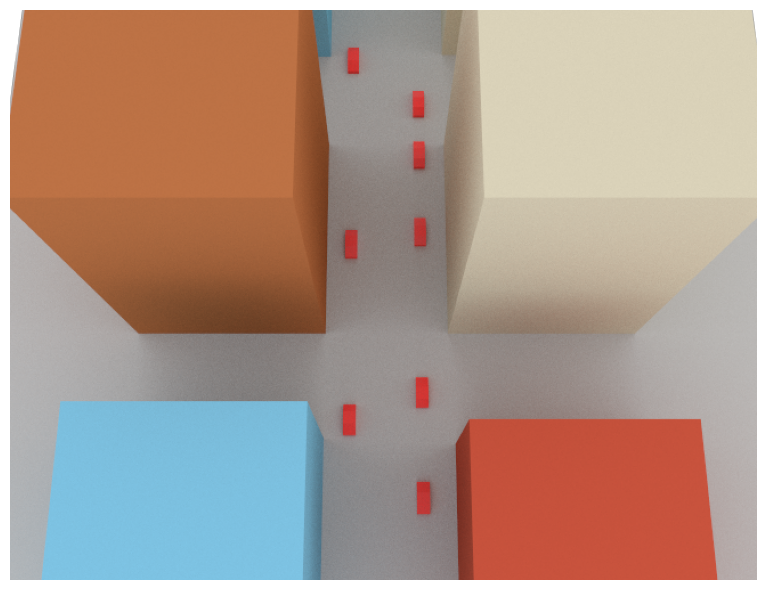

In [3]:
scene = load_scene(sionna.rt.scene.simple_street_canyon_with_cars)
scene.add(Camera("cam", position=[50,0,130], look_at=[10,0,0]))
if no_preview:
    scene.render(camera="cam", num_samples=512);

In [4]:
%%skip_if no_preview
scene.preview()

The list of all scene objects can be accessed as follows:

In [5]:
scene.objects

{'building_1': <sionna.rt.scene_object.SceneObject at 0x7fccec9c1b70>,
 'building_2': <sionna.rt.scene_object.SceneObject at 0x7fccec9c18d0>,
 'building_3': <sionna.rt.scene_object.SceneObject at 0x7fccec9c1990>,
 'building_4': <sionna.rt.scene_object.SceneObject at 0x7fccec9c1900>,
 'building_5': <sionna.rt.scene_object.SceneObject at 0x7fccec9c1f90>,
 'building_6': <sionna.rt.scene_object.SceneObject at 0x7fccec9c1ff0>,
 'car_1': <sionna.rt.scene_object.SceneObject at 0x7fccec9c2050>,
 'car_2': <sionna.rt.scene_object.SceneObject at 0x7fccec9c20b0>,
 'car_3': <sionna.rt.scene_object.SceneObject at 0x7fccec9c2110>,
 'car_4': <sionna.rt.scene_object.SceneObject at 0x7fccec9c2170>,
 'car_5': <sionna.rt.scene_object.SceneObject at 0x7fccec9c21d0>,
 'car_6': <sionna.rt.scene_object.SceneObject at 0x7fccec9c2230>,
 'car_7': <sionna.rt.scene_object.SceneObject at 0x7fccec9c2290>,
 'car_8': <sionna.rt.scene_object.SceneObject at 0x7fccec9c22f0>,
 'floor': <sionna.rt.scene_object.SceneObject 

Let us now inspect the position and orientation of one of the cars:

In [6]:
car_2 = scene.get("car_2")
print("Position: ", car_2.position.numpy())
print("Orientation: ", car_2.orientation.numpy())

Position:  [25.         5.5999994  0.7500001]
Orientation:  [0. 0. 0.]


The position of an object corresponds to the center of its axis-aligned bounding box.
By default, the orientation of every scene object is `[0,0,0]`. 
We can now change the position and orientation of the car as follows:

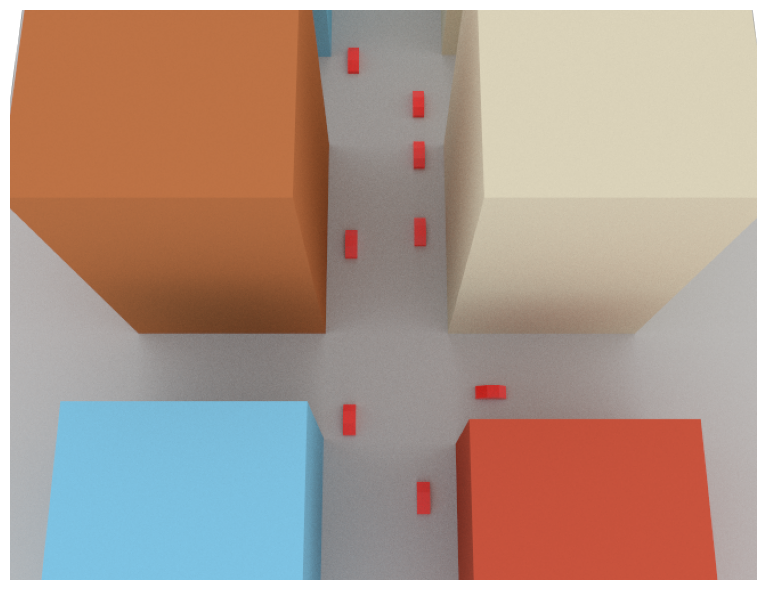

In [7]:
# Move the car 10m along the y-axis
car_2.position += [0, 10, 0]

# And rotate it by 90 degree around the z-axis
car_2.orientation = [np.pi/2, 0, 0]

if no_preview:
    scene.render(camera="cam", num_samples=512);
else:
    scene.preview(); # You do not need to open a new preview, the preview above will update

Next, we will visualize coverage maps for different positions of the cars in the scene, assuming that one of the cars is equipped with a transmit antenna:

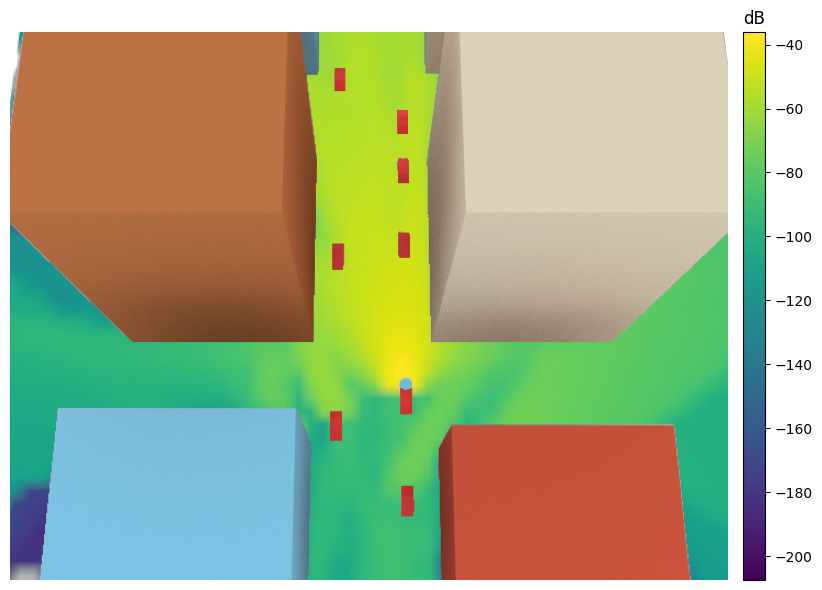

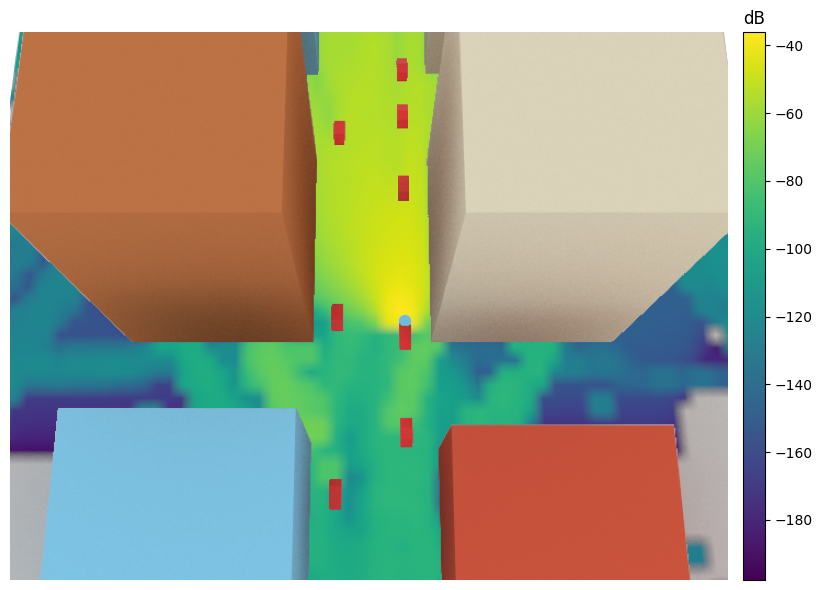

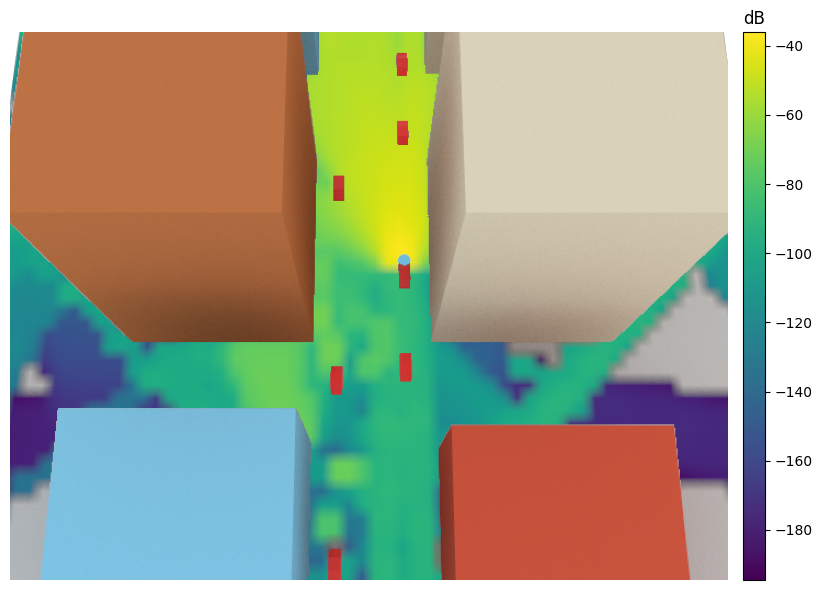

In [8]:
scene = load_scene(sionna.rt.scene.simple_street_canyon_with_cars)
scene.add(Camera("cam", position=[50,0,130], look_at=[10,0,0]))

# Configure a transmitter that is located at the front of "car_2"
scene.add(Transmitter("tx", position=[22.7, 5.6, 0.75], orientation=[np.pi,0,0]))
scene.tx_array = PlanarArray(1,1,0.5,0.5,"tr38901","V")
scene.rx_array = scene.tx_array

# Move cars along straight lines for a couple of steps
displacement_vec = [10, 0, 0]
num_displacements = 2
for _ in range(num_displacements+1):

    # Compute and render a coverage map at 0.5m above the ground
    cm = scene.coverage_map(num_samples=10e6,
                            max_depth=5,
                            diffraction=True,
                            cm_center=[0,0,0.5],
                            cm_orientation=[0,0,0],
                            cm_size=[186,121],
                            cm_cell_size=[2,2])
    scene.render("cam", coverage_map=cm)

    # Move TX to next position
    scene.get("tx").position -= displacement_vec

    # Move cars driving in -x direction
    for j in range(1,6):
        scene.get(f"car_{j}").position -= displacement_vec

    # Move cars driving in x direction
    for j in range(6,9):
        scene.get(f"car_{j}").position += displacement_vec

## Time Evolution of Channels Via Doppler Shift

In the previous section, we have seen how the position and orientation of objects in a scene can be modified. However, if we want to model the evolution of channels over very short time horizons, this approach becomes impractical. An alternative, consists in assigning to all moving objects
a velocity vector $\mathbf{v}_i\in\mathbb{R}^3$ based on which path-wise Doppler shifts can be computed. Let us now load a simple scene with a single reflector and modify its velocity.

In [9]:
# Load scene with a single reflector
scene = load_scene(sionna.rt.scene.simple_reflector)

# Inspect the velocity of this object
print("Velocity vector: ", scene.get("reflector").velocity.numpy())

# Update velocity vector
scene.get("reflector").velocity = [0, 0, -20]
print("Velocity vector after update: ", scene.get("reflector").velocity.numpy())

Velocity vector:  [0. 0. 0.]
Velocity vector after update:  [  0.   0. -20.]


Next, we will add a transmitter and receiver to the scene and compute the propagation paths:

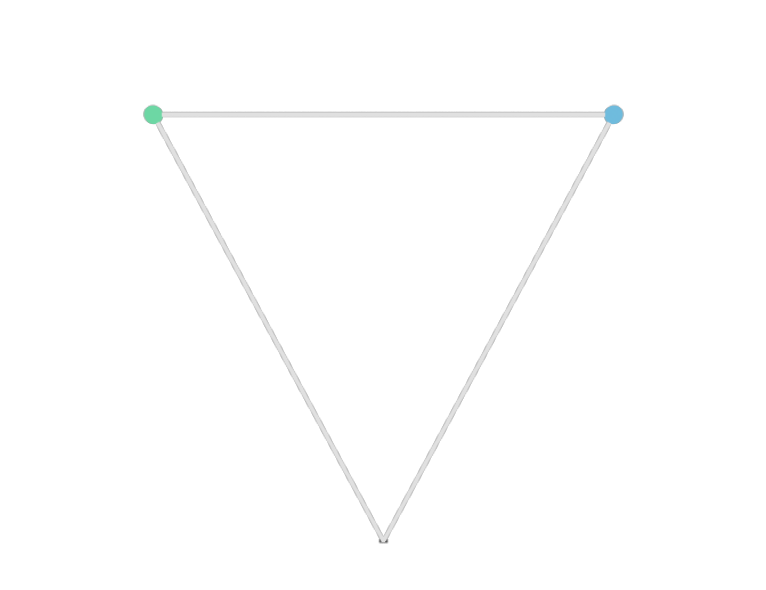

In [10]:
# Configure arrays for all transmitters and receivers in the scene
scene.tx_array = PlanarArray(1,1,0.5,0.5,"iso","V")
scene.rx_array = scene.tx_array

# Add a transmitter and a receiver
scene.add(Transmitter("tx", [-25,0.1,50]))
scene.add(Receiver("rx",    [ 25,0.1,50]))

# Compute paths
paths = scene.compute_paths(max_depth=1)
paths.normalize_delays = False # Do not normalize the delays such that the first path arrives at tau=0

# Visualize the scene and propagation paths
if no_preview:
    scene.add(Camera("cam", position=[0, 100, 50], look_at=[0,0,30]))
    scene.render(paths=paths, camera="cam", num_samples=512);

In [11]:
%%skip_if no_preview
scene.preview(paths=paths)

Every path has a property `Paths.doppler` that corresponds to the aggregated Doppler shift due to the movement of objects it intersects. This property does not account for the additional Doppler shifts caused by possible movements of the transmitter and receiver.

In [12]:
print("Path type (0=LoS, 1=Specular reflection): ", paths.types.numpy())
print("Doppler shifts (Hz): ", paths.doppler.numpy())

Path type (0=LoS, 1=Specular reflection):  [[0 1]]
Doppler shifts (Hz):  [[[[   0.      -417.68832]]]]


### Example: Delay-Doppler Spectrum

We will now use the Doppler shifts to compute a time-varying channel impulse response and estimate its Delay-Doppler spectrum.
To this end, we assume that 1024 subsequent symbols of an OFDM system with 1024 subcarriers can be observed, assuming a subcarrier spacing of 30kHz. This will define the following resolutions in the delay and Doppler domains:

In [13]:
rg = ResourceGrid(num_ofdm_symbols=1024,
                  fft_size=1024,
                  subcarrier_spacing=30e3)

delay_resolution = rg.ofdm_symbol_duration/rg.fft_size
print("Delay   resolution (ns): ", int(delay_resolution/1e-9))

doppler_resolution = rg.subcarrier_spacing/rg.num_ofdm_symbols
print("Doppler resolution (Hz): ", int(doppler_resolution))

Delay   resolution (ns):  32
Doppler resolution (Hz):  29


In addition to the velocity of the reflector, we also assume that the transmitter is moving. Its velocity vector will be provided during the call of the ``apply_doppler()`` function.

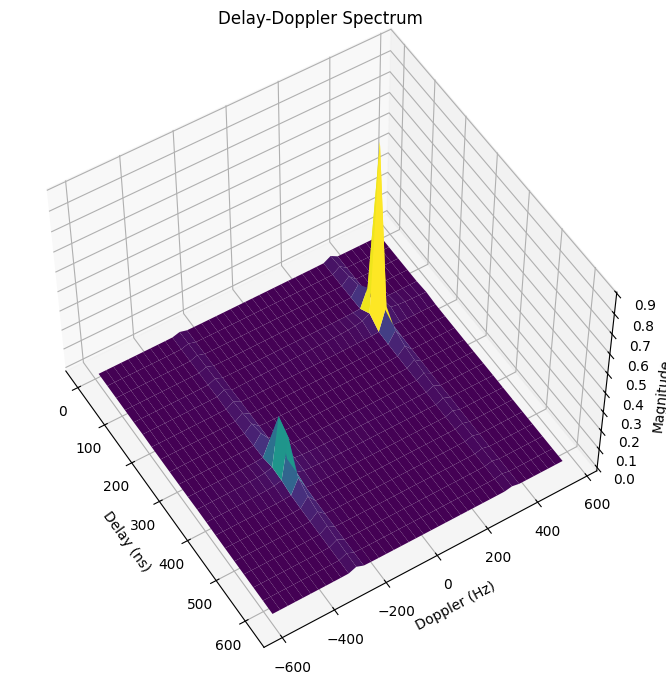

In [14]:
# Compute time evolution of the channel impulse response
tx_velocity = [30,0,0]
paths.apply_doppler(sampling_frequency=1/rg.ofdm_symbol_duration,
                    num_time_steps=rg.num_ofdm_symbols,
                    tx_velocities=tx_velocity)


### Compute the Delay-Doppler spectrum
# Determine subcarrier frequencies
frequencies = subcarrier_frequencies(rg.fft_size, rg.subcarrier_spacing)

# Squeeze useless dimensions
# [num_time_steps, fft_size]
h = tf.squeeze(cir_to_ofdm_channel(frequencies, *paths.cir(), normalize=True))

# Apply an FFTshift to bring subcarriers in the
# correct order for an IFFT
h = np.fft.fftshift(h, axes=1)

# Apply IFFT to subcarrier dimension to
# convert frequency to delay domain
h_delay = np.fft.ifft(h, axis=1)/np.sqrt(rg.fft_size)

# Apply FFT to time-step dimension to
# convert time to Doppler domain
h_delay_doppler = np.fft.fft(h_delay, axis=0)/np.sqrt(rg.fft_size)

# Apply FFTShift to bring Doppler dimension in the correct
# order for visualization
h_delay_doppler = np.fft.fftshift(h_delay_doppler, axes=0)

# Compute meshgrid for visualization of the Delay-Doppler spectrum
doppler_bins = np.arange(-rg.num_ofdm_symbols/2*doppler_resolution,
                          rg.num_ofdm_symbols/2*doppler_resolution,
                         doppler_resolution)

delay_bins = np.arange(0,
                       rg.fft_size*delay_resolution,
                       delay_resolution) / 1e-9

x, y = np.meshgrid(delay_bins, doppler_bins)

# Visualize Delay-Doppler spectrum
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(111, projection='3d')

# We only visualize the relevant part of the spectrum
offset = 20
x_start = int(rg.fft_size/2)-offset
x_end = int(rg.fft_size/2)+offset
y_start = 0
y_end = offset
x_grid = x[x_start:x_end,y_start:y_end]
y_grid = y[x_start:x_end,y_start:y_end]
z_grid = np.abs(h_delay_doppler[x_start:x_end,y_start:y_end])

surf = ax.plot_surface(x_grid,
                       y_grid,
                       z_grid,
                       cmap='viridis', edgecolor='none')

ax.set_xlabel('Delay (ns)')
ax.set_ylabel('Doppler (Hz)')
ax.set_zlabel('Magnitude');
ax.zaxis.labelpad=2
ax.view_init(elev=53, azim=-32)
ax.set_title("Delay-Doppler Spectrum");

As expected, we can observe two peaks in the Delay-Doppler spectrum above. The first at a delay of around 160ns, and the second at a delay of approximately 370ns. The respective Doppler shifts are around 350Hz and -260Hz.

Next, we will compute the exact Doppler shifts based on the equation provided in the [Background Information](#Background-Information) that should match the peaks in the Delay-Doppler spectrum.

In [15]:
# Compute outgoing directions for the LoS and reflected path
k_t_los = r_hat(paths.theta_t[0,0,0,0], paths.phi_t[0,0,0,0])
k_t_ref = r_hat(paths.theta_t[0,0,0,1], paths.phi_t[0,0,0,1])

# Compute the Doppler shifts due to movement of the transmitter
doppler_tx_los = np.sum(k_t_los*tx_velocity)/scene.wavelength
doppler_tx_ref = np.sum(k_t_ref*tx_velocity)/scene.wavelength

# Compute the overall Doppler shifts
doppler_los = doppler_tx_los + paths.doppler[0,0,0,0]
doppler_ref = doppler_tx_ref + paths.doppler[0,0,0,1]

print("Delay - LoS Path (ns) :", paths.tau[0,0,0,0].numpy()/1e-9)
print("Doppler - LoS Path (Hz) :", doppler_los.numpy())

print("Delay - Reflected Path (ns) :", paths.tau[0,0,0,1].numpy()/1e-9)
print("Doppler - Reflected Path (Hz) :", doppler_ref.numpy())

Delay - LoS Path (ns) : 166.78205838616122
Doppler - LoS Path (Hz) : 350.2423
Delay - Reflected Path (ns) : 372.93600030352536
Doppler - Reflected Path (Hz) : -261.05524


## Comparison of Doppler- vs Position-based Time Evolution

We will now compare a time-varying channel frequency impulse response generated by the application of Doppler shifts against another one obtained by physically moving objects in a scene and retracing the paths.

The same scene as in the first section will be used where a transmitter is placed on a moving car. However, we now also place a receiver on another car and assume that all cars in the scene are moving along a linear trajectory.

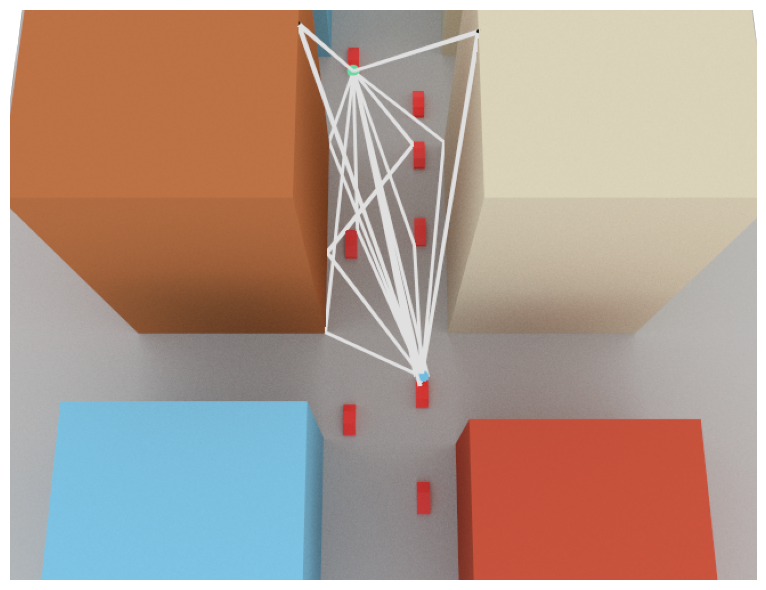

In [16]:
scene = load_scene(sionna.rt.scene.simple_street_canyon_with_cars)
scene.add(Camera("cam", position=[50,0,130], look_at=[10,0,0]))

# Parameters for ray tracing
max_depth = 3
diffraction = True

# TX and RX have directional antennas
scene.tx_array = PlanarArray(1,1,0.5,0.5,"tr38901","V")
scene.rx_array = scene.tx_array

# TX and RX are installed at the front of two different cars.
# The directive antennas ensure that paths reaching an antenna from the back are close to zero.
scene.add(Transmitter("tx", position=[22.7, 5.6, 0.75], orientation=[np.pi,0,0]))
scene.add(Receiver("rx", position=[-27.8,-4.9, 0.75]))

# Configure an OFDM resource grid
rg = ResourceGrid(num_ofdm_symbols=128,
                  fft_size=1024,
                  subcarrier_spacing=30e3)

frequencies = subcarrier_frequencies(rg.fft_size, rg.subcarrier_spacing)

# Define a velocity vector and the corresponding displacement over the duration
# of one OFDM symbol
velocity_vec = np.array([10,0,0])
displacement_vec = velocity_vec*rg.ofdm_symbol_duration

# Assign velocity vector to cars driving in -x direction
for j in range(1,6):
    scene.get(f"car_{j}").velocity = -velocity_vec

# Assign velocity vector to cars driving in x direction
for j in range(6,9):
    scene.get(f"car_{j}").velocity = velocity_vec

# Compute paths and apply Doppler shift for time evolution
paths = scene.compute_paths(max_depth=max_depth, diffraction=diffraction)
paths.normalize_delays = False
paths.apply_doppler(sampling_frequency=1/rg.ofdm_symbol_duration,
                    num_time_steps=rg.num_ofdm_symbols,
                    tx_velocities=-velocity_vec,
                    rx_velocities=velocity_vec)

# Compute the corresponding channel frequency responses
h_dop = tf.squeeze(cir_to_ofdm_channel(frequencies, *paths.cir()))

# Visualize the scene and propagation paths
if no_preview:
    scene.render(paths=paths, camera="cam", num_samples=512);

In [17]:
%%skip_if no_preview
scene.preview(paths=paths)

In the next cell, we compute a sequence of channel frequency responses by moving all cars as well as the transmitter and receiver in the scene. After each step, propagation paths are traced and the corresponding channel frequency response is computed.

In [18]:
paths = scene.compute_paths(max_depth=max_depth, diffraction=diffraction)
paths.normalize_delays = False
# Reshape to [1, num_subcarriers]
h_sim = tf.reshape(cir_to_ofdm_channel(frequencies, *paths.cir()), [1, -1])

for i in range(rg.num_ofdm_symbols-1):
    # Move TX and RX to next position
    scene.get("tx").position -= displacement_vec
    scene.get("rx").position += displacement_vec

    # Move cars driving in -x direction to the next position
    for j in range(1,6):
        scene.get(f"car_{j}").position -= displacement_vec

    # Move cars driving in +x direction to the next position
    for j in range(6,9):
        scene.get(f"car_{j}").position += displacement_vec

    # Compute channel frequency response
    paths = scene.compute_paths(max_depth=max_depth, diffraction=diffraction)
    paths.normalize_delays = False
    h = tf.reshape(cir_to_ofdm_channel(frequencies, *paths.cir()), [1, -1])

    # Concatenate along the time dimensions
    h_sim = tf.concat([h_sim, h], axis=0)

Next, we visualize the the time evolution of a few subcarriers as well as some snapshots of the full channel frequency response.

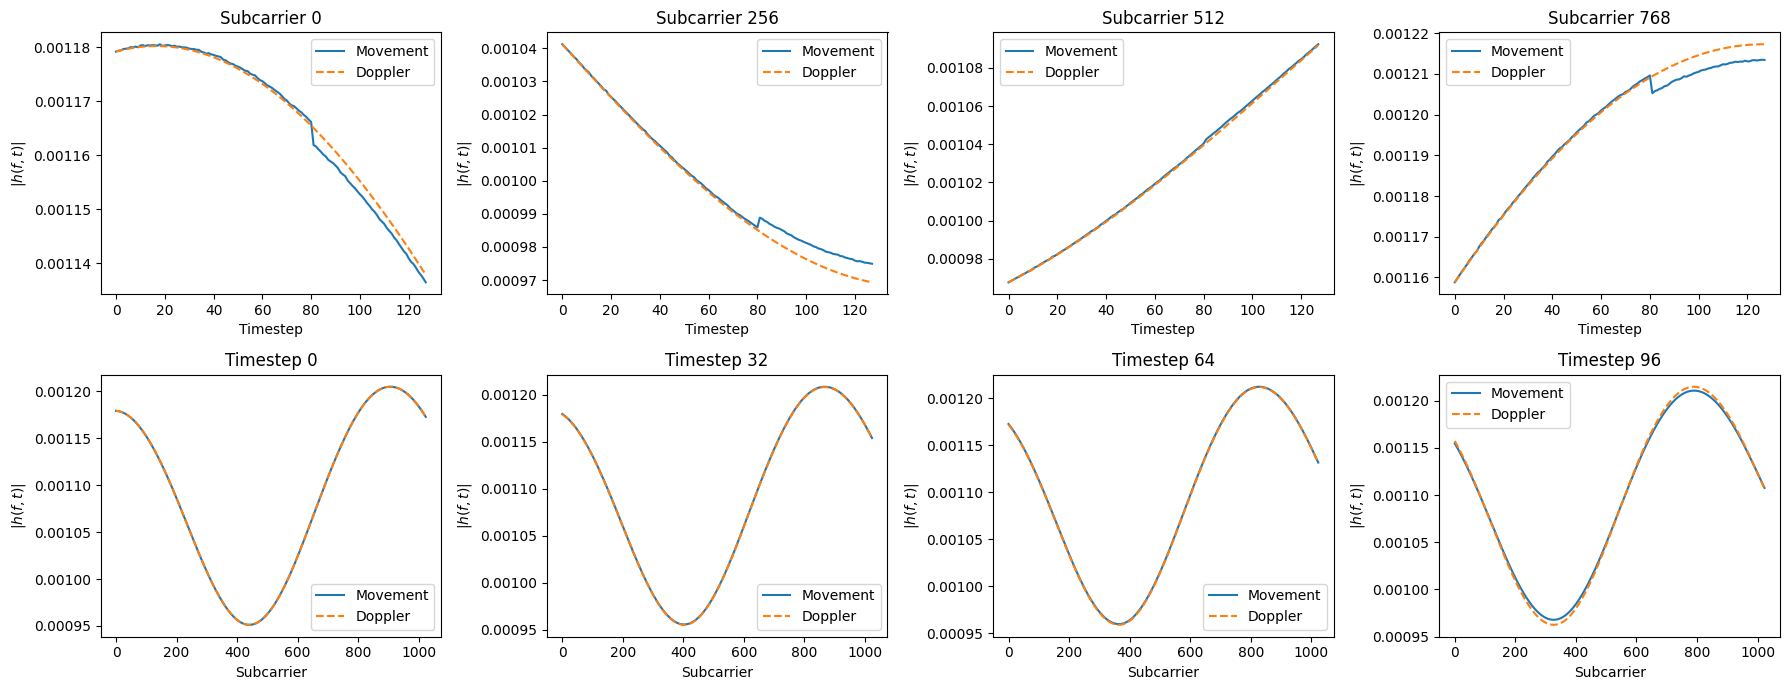

In [19]:
subcarriers = np.arange(0, 1024, 256)
timesteps =  np.arange(0, 128, 32)

fig, axs = plt.subplots(2, 4, figsize=(18, 7))
for i,j in enumerate(subcarriers):
    axs[0,i].plot(np.arange(rg.num_ofdm_symbols), np.abs(h_sim[:,j]))
    axs[0,i].plot(np.arange(rg.num_ofdm_symbols), np.abs(h_dop[:,j]), "--")
    axs[0,i].set_xlabel("Timestep")
    axs[0,i].set_ylabel(r"$|h(f,t)|$")
    axs[0,i].set_title(f"Subcarrier {j}")
    axs[0,i].legend(["Movement", "Doppler"])


for i,j in enumerate(timesteps):
    axs[1,i].plot(np.arange(rg.fft_size), np.abs(h_sim[j,:]))
    axs[1,i].plot(np.arange(rg.fft_size), np.abs(h_dop[j,:]), "--")
    axs[1,i].set_xlabel("Subcarrier")
    axs[1,i].set_ylabel(r"$|h(f,t)|$")
    axs[1,i].set_title(f"Timestep {j}")
    axs[1,i].legend(["Movement", "Doppler"])

plt.tight_layout()
plt.show()

From the figures above, we can see that there is until time step 80 no noticeable difference between the Doppler-based channel evolution and the one based on physically moving objects. At time step 80, some paths (diss-)appear and the Doppler-based time-evolution becomes less accurate. 

## Summary
We have discussed two different ways to simulate mobility in Sionna RT. One can either move objects in a scene and recompute paths or compute the time evolution of channels synthetically based on the Doppler shifts that are obtained from velocity vectors of the scene objects.

The former approach is computationally intensive but accurate while the latter is much faster but only accurate over short time spans during which the scene objects have moved very short distances.

Both approaches can be combined to simulate mobility over longer periods of time.

We hope you enjoyed our dive into the simulation of mobility with Sionna RT. You may also want to explore our other [tutorials](https://nvlabs.github.io/sionna/tutorials.html#ray-tracing).